In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#pip install openpyxl --upgrade

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn import metrics
from pprint import pprint
pd.set_option('display.max_columns', 50)
#pd.set_option('display.max_rows', 50)
data = r"C:\Users\jim\Dropbox\Sample projects\Basketball analytics\Euroleague data"


### Calculate Elo

The elo ratings of each time are calculated based on the following article: \
https://towardsdatascience.com/predicting-the-outcome-of-nba-games-with-machine-learning-a810bb768f20

**Set initial value 1500 for all teams**

In [2]:
df_teams = pd.read_csv(rf'{data}\output\intermediate\df_teams.csv')
df_teams["Elo_curr"] = np.nan
df_teams["OPP Elo_curr"] = np.nan
df_teams["Elo"] = np.nan
df_teams["OPP Elo"] = np.nan
df_teams.loc[df_teams["ROUND"] == 1, "Elo_curr"] = 1500
df_teams.loc[df_teams["ROUND"] == 1, "OPP Elo_curr"] = 1500

elo = {}
rounds = df_teams["ROUND"].max()

for r in range(1,rounds+2):
    #print("ROUND", r)
    match = df_teams[df_teams["ROUND"] == r]
    match["Elo_diff"] = match["OPP Elo_curr"]-match["Elo_curr"]          
    match["E_team"] = 1/(1+10**(match["Elo_diff"]/400))
    match["k"] = (20*(abs(match["+ / -"])+3)**0.8)/(7.5+0.006*(abs(match["Elo_diff"])))
    match["Elo"] = match["Elo_curr"] + match["k"]*(match["W"]-match["E_team"])

    match["OPP Elo_diff"] = match["Elo_curr"]-match["OPP Elo_curr"]          
    match["OPP E_team"] = 1/(1+10**(match["OPP Elo_diff"]/400))
    match["OPP Elo"] = match["OPP Elo_curr"] + match["k"]*(match["OPP W"]-match["OPP E_team"])
    match = match[["ROUND", "team", "Elo", "OPP Elo"]]
    
    df_teams = df_teams.merge(match, how='left', on=["ROUND", "team"], suffixes=('', '_r'))
    df_teams.loc[df_teams["Elo"].isna()==True, "Elo"] = df_teams["Elo_r"]
    df_teams.loc[df_teams["OPP Elo"].isna()==True, "OPP Elo"] = df_teams["OPP Elo_r"]
    df_teams.drop(['Elo_r', 'OPP Elo_r'], axis=1, inplace=True)
    df_teams["Elo_curr"] = df_teams.groupby(['team'])["Elo"].shift(1)
    df_teams["OPP Elo_curr"] = df_teams.groupby(['opp'])["OPP Elo"].shift(1)

df_teams.drop(['Elo_curr', 'OPP Elo_curr'], axis=1, inplace=True)

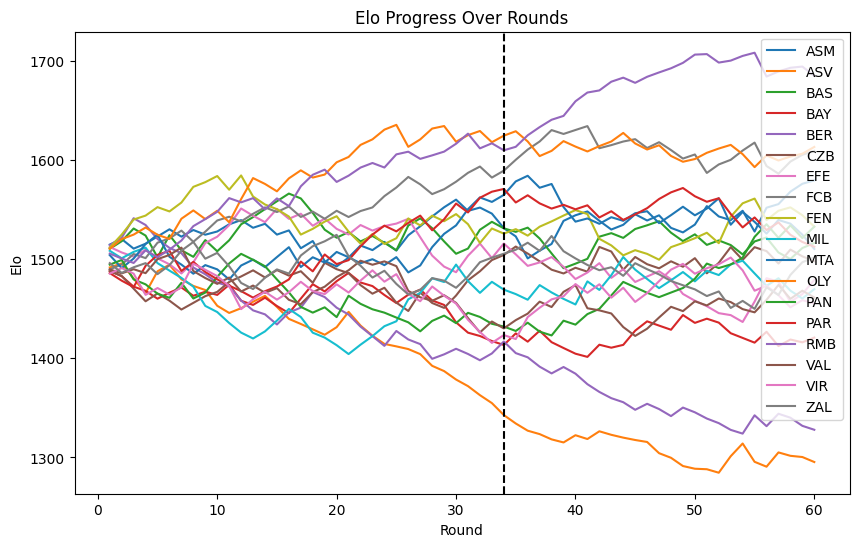

In [4]:
elo = df_teams[["ROUND", "team", "Elo"]]
elo_by_team = elo.groupby("team")

plt.figure(figsize=(10, 6))

for team, group in elo_by_team:
    plt.plot(group["ROUND"], group["Elo"], label=team)

plt.xlabel("Round")
plt.ylabel("Elo")
plt.title("Elo Progress Over Rounds")
plt.axvline(x=34, color = 'k', linestyle = '--')
plt.legend()
plt.grid(False)
plt.show()

**Plot correlation with Home Win**

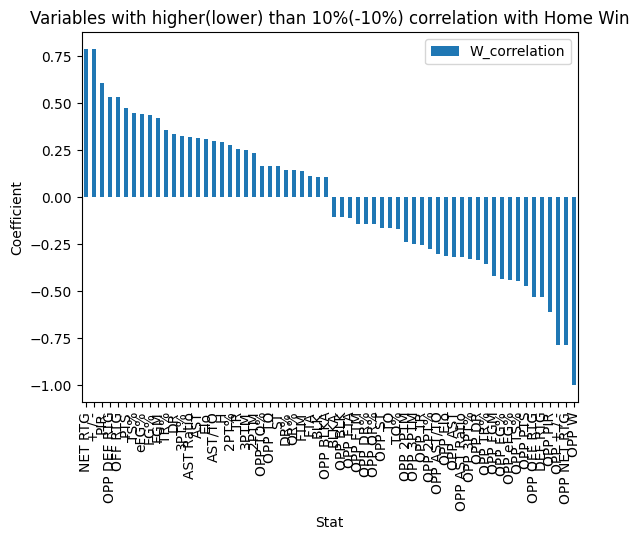

In [5]:
corr_coeff = 0.1
df_teams_stats = df_teams.iloc[:, 5:]
df_corr = df_teams_stats.corr()
W_corr = df_corr[0:1].T
W_corr.reset_index(inplace=True)
W_corr.rename(columns = {'W':'W_correlation', 'index': 'Stat'}, inplace = True)
W_corr = W_corr[1:]
W_corr_str = W_corr[(W_corr["W_correlation"] >= corr_coeff) | ((W_corr["W_correlation"] <= -corr_coeff))]
W_corr_str.reset_index(inplace=True, drop=True)
W_corr_str.sort_values(by=['W_correlation'], ascending=False).plot(x="Stat", ylabel="Coefficient", kind="bar", title="Variables with higher(lower) than 10%(-10%) correlation with Home Win")

corr_vars = W_corr_str.T
corr_vars_name = corr_vars.iloc[0] #grab the first row for the header
df_teams = df_teams[["Season", "Season_Round", "ROUND", "team", "opp", "W"] + list(corr_vars_name) ] #keep the subset of variables with strong correlation

**Calculate a moving average to declare each team's recent performance, namely a moving average of the last 10 games**

In [6]:
n = 10
mavg = {}
for r in range(1,rounds+1):
    #print(r)
    mavg[r] = df_teams[(df_teams["ROUND"]>=r-n) & (df_teams["ROUND"]<r)]
    #mavg[r].drop(['ROUND', 'opp', 'W'], axis=1, inplace=True)
    mavg[r].drop(['Season', 'Season_Round', 'ROUND', 'opp'], axis=1, inplace=True)
    mavg[r] = mavg[r].groupby(["team"]).mean()
    mavg[r] = mavg[r].add_prefix('L_')
    mavg[r] = mavg[r].add_suffix('_mavg')
    mavg[r].reset_index(inplace=True)
    mavg[r]["ROUND"] = r
    cols = list(mavg[r].columns)
    cols.insert(0, cols.pop(cols.index('ROUND')))
    mavg[r] = mavg[r].loc[:, cols]
    
mavg = pd.concat(mavg.values(), ignore_index=True)

df = mavg.merge(df_teams[["ROUND", "team", "opp", "W", "H"]], how='right', on=["ROUND", "team"], suffixes=('_x', '_y'))
cols = list(df.columns)
cols.insert(2, cols.pop(cols.index('opp')))
cols.insert(3, cols.pop(cols.index('W')))
df = df.loc[:, cols]
#df.rename(columns = {'HW':'result'}, inplace = True)
#df.loc[df["result"] == 0, "result"] = 2

**Define opponents' moving averages**

In [7]:
cols = list(df.columns)
#for c in cols:
#    df[c + "_next"] = df.groupby(["team"])[c].shift(1)
    
curr_opp = {}
for r in range(1,rounds+1):
   # print("ROUND", r)
    match = df[df["ROUND"] == r]
    for c in cols:
        match["currOPP_" + c] = np.nan
    match.reset_index(drop=True, inplace=True)
    for i in range(0,len(match)):
        for j in range(0,len(match)):
            if match["team"][i] == match["opp"][j]:
                for c in cols:
                    match["currOPP_" + c][i] = match[c][j]
    currOPP_columns = match.filter(like='currOPP_', axis=1).columns.tolist()
    match_columns = ["ROUND", "team"] + currOPP_columns
    curr_opp[r] =  match[match_columns]
    
curr_opp = pd.concat(curr_opp.values(), ignore_index=True)
curr_opp.drop(["currOPP_ROUND", "currOPP_team", "currOPP_opp", "currOPP_W"], axis=1, inplace=True)
df = df.merge(curr_opp, how='right', on=["ROUND", "team"], suffixes=('_x', '_y'))                                

**Transform the dataframe to have each game as a unit of observation**

In [8]:
df_match = df[df["H"] == 1]

df_match.reset_index(drop=True, inplace=True)
df_match["match_id"] = df_match["ROUND"].astype(str) + "_" + df_match["team"] + "-" + df_match["opp"]
df_match["result"] = np.nan
df_match.loc[df_match["W"] == 1, "result"] = 1
df_match.loc[df_match["W"] == 0, "result"] = 2

df_match.drop(["team", "opp", "W"], axis=1, inplace=True)


cols = list(df_match.columns)
cols.insert(4, cols.pop(cols.index('result')))
cols.insert(1, cols.pop(cols.index('match_id')))
cols.insert(2, cols.pop(cols.index('result')))
df_match = df_match.loc[:, cols]

## Predict the Outcome of Games Based on Team Statistics and Elo Ratings

## 1. In-sample prediction

### Split sample between train and test

In [9]:
rounds = df_match[df_match["result"].isna()==False]["ROUND"].max()
f_df = df_match[(df_match["ROUND"]>1) & (df_match["ROUND"]<=rounds)]
#f_df.drop(["H"], axis=1, inplace=True)
seed = 82
x = f_df.iloc[:, 3:]
y = f_df[["result"]]
length = len(f_df)
split = 100

x_train = x[:length-split]
x_test = x[length-split:]
y_train = y[:length-split]
y_test = y[length-split:]

### Logistic Regression model: fine tuning

In [10]:
iterations = [50,80,90,100,110,120,130,140,150]
verb = [0,1,2,5,10,15,20]
max_score = 0

for i in iterations:
    for v in verb:
        LR_model = LogisticRegression(max_iter=i, verbose=v, random_state=seed)
        LR_model.fit(x_train, y_train)
        y_pred_lr = LR_model.predict(x_test)
        score = metrics.accuracy_score(y_test, y_pred_lr)
       # print("For ", i," iterations and ", v, "verbose:", score)
        if score >= max_score:
            LR_max_score = score
            LR_max_i = i
            LR_max_v = v
            
print("max score:", LR_max_score)
print("Best i:", LR_max_i)
print("Best v:", LR_max_v)

LR_model = LogisticRegression(max_iter=LR_max_i, verbose=LR_max_v, random_state=seed)
LR_model.fit(x_train, y_train)

y_pred_lr = LR_model.predict(x_test)
print("Logistic Regression accuracy:", metrics.accuracy_score(y_test, y_pred_lr))
y_pred_proba_lr = LR_model.predict_proba(x_test)

match_id = f_df[length-split:][["match_id"]]
match_id.reset_index(inplace=True, drop=True)
pred = pd.DataFrame(y_pred_lr)
pred.rename(columns =  {0:'forecast'}, inplace = True)
pred_proba = pd.DataFrame(y_pred_proba_lr)
pred_proba.rename(columns =  {0:'prob 1', 1: 'prob 2'}, inplace = True)
pred = pd.merge(pred, pred_proba, left_index=True, right_index=True)

match_id = pd.merge(match_id, pred, left_index=True, right_index=True)
for_act = f_df[["match_id", "result"]][length-split:]
for_act = for_act.merge(match_id, how='right', on=["match_id"], suffixes=('_x', '_y'))
for_act.rename(columns = {'result': 'actual result'}, inplace = True)
for_act = for_act[["match_id", 'forecast', "prob 1", "prob 2", "actual result"]]
LR_for_act = for_act.copy()

print(LR_model)
LR_for_act



[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    3.2s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    3.2s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Do

max score: 0.69
Best i: 150
Best v: 20
Logistic Regression accuracy: 0.69
LogisticRegression(max_iter=150, random_state=82, verbose=20)


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.8s


,match_id,forecast,prob 1,prob 2,actual result
0,49_BAY-EFE,1.0,0.717810,0.282190,1.0
1,50_MTA-CZB,1.0,0.779320,0.220680,2.0
2,50_VAL-VIR,2.0,0.482437,0.517563,1.0
3,50_RMB-PAR,1.0,0.854526,0.145474,1.0
4,50_EFE-BAS,1.0,0.596419,0.403581,2.0
...,...,...,...,...,...
95,60_BAS-ASV,1.0,0.656840,0.343160,1.0
96,60_CZB-ZAL,1.0,0.752379,0.247621,2.0
97,60_PAN-FEN,1.0,0.670695,0.329305,1.0
98,60_FCB-BER,1.0,0.897687,0.102313,1.0


In [11]:
LR_model = LogisticRegression(max_iter=LR_max_i, verbose=LR_max_v, random_state=seed)
LR_model.fit(x_train, y_train)
#LR_importances = LR_model.feature_importances_


y_pred_lr = LR_model.predict(x_test)
print("Logistic Regression accuracy:", metrics.accuracy_score(y_test, y_pred_lr))
y_pred_proba_lr = LR_model.predict_proba(x_test)

match_id = f_df[length-split:][["match_id"]]
match_id.reset_index(inplace=True, drop=True)
pred = pd.DataFrame(y_pred_lr)
pred.rename(columns =  {0:'forecast'}, inplace = True)
pred_proba = pd.DataFrame(y_pred_proba_lr)
pred_proba.rename(columns =  {0:'prob 1', 1: 'prob 2'}, inplace = True)
pred = pd.merge(pred, pred_proba, left_index=True, right_index=True)

match_id = pd.merge(match_id, pred, left_index=True, right_index=True)
for_act = f_df[["match_id", "result"]][length-split:]
for_act = for_act.merge(match_id, how='right', on=["match_id"], suffixes=('_x', '_y'))
for_act.rename(columns = {'result': 'actual result'}, inplace = True)
for_act = for_act[["match_id", 'forecast', "prob 1", "prob 2", "actual result"]]
LR_for_act = for_act.copy()

print(LR_model)
LR_for_act


Logistic Regression accuracy: 0.69
LogisticRegression(max_iter=150, random_state=82, verbose=20)


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.8s


,match_id,forecast,prob 1,prob 2,actual result
0,49_BAY-EFE,1.0,0.717810,0.282190,1.0
1,50_MTA-CZB,1.0,0.779320,0.220680,2.0
2,50_VAL-VIR,2.0,0.482437,0.517563,1.0
3,50_RMB-PAR,1.0,0.854526,0.145474,1.0
4,50_EFE-BAS,1.0,0.596419,0.403581,2.0
...,...,...,...,...,...
95,60_BAS-ASV,1.0,0.656840,0.343160,1.0
96,60_CZB-ZAL,1.0,0.752379,0.247621,2.0
97,60_PAN-FEN,1.0,0.670695,0.329305,1.0
98,60_FCB-BER,1.0,0.897687,0.102313,1.0


### Random Forest Classifier: fine tuning

In [12]:
from sklearn.ensemble import RandomForestClassifier

trees= [100,150,200]
crit = ["gini", "entropy", "log_loss"]
samples = [2, 3, 5, 7, 10]
min_samples_leaf = [3,5,6,7]

max_score = 0

for t in trees:
    for c in crit:
        for s in samples:
            for sl in min_samples_leaf:
                RF_model = RandomForestClassifier(n_estimators=t, criterion=c, min_samples_split= s, min_samples_leaf= sl, random_state=seed)
                RF_model.fit(x_train, y_train)
                y_pred_rf = RF_model.predict(x_test)
               # print("trees:", t, "criterion:", c, "samples:", s, "samples leaf", sl)
                score = metrics.accuracy_score(y_test, y_pred_rf)
               # print(score)
                if score >= max_score:
                    RF_max_score = score
                    RF_max_t = t
                    RF_max_c = c
                    RF_max_s = s
                    RF_max_sl = sl

print("Maximum score:", RF_max_score)                
print("Best n_estimators:", RF_max_t)
print("Best criterion:", RF_max_c)
print("Best min_samples_split:", RF_max_s)
print("Best min_samples_leaf:", RF_max_sl)

RF_model = RandomForestClassifier(n_estimators=RF_max_t, criterion=RF_max_c, min_samples_split= RF_max_s, min_samples_leaf= RF_max_sl, random_state=seed)
RF_model.fit(x_train, y_train)
y_pred_rf = RF_model.predict(x_test)
score = metrics.accuracy_score(y_test, y_pred_rf)
print("RandomForest accuracy:", score)
y_pred_proba_rf = RF_model.predict_proba(x_test)


match_id = f_df[length-split:][["match_id"]]
match_id.reset_index(inplace=True, drop=True)
pred = pd.DataFrame(y_pred_rf)
pred.rename(columns =  {0:'forecast'}, inplace = True)
pred_proba = pd.DataFrame(y_pred_proba_rf)
pred_proba.rename(columns =  {0:'prob 1', 1: 'prob 2'}, inplace = True)
pred = pd.merge(pred, pred_proba, left_index=True, right_index=True)

match_id = pd.merge(match_id, pred, left_index=True, right_index=True)
for_act = f_df[["match_id", "result"]][length-split:]
for_act = for_act.merge(match_id, how='right', on=["match_id"], suffixes=('_x', '_y'))
for_act.rename(columns = {'result': 'actual result'}, inplace = True)
for_act = for_act[["match_id", 'forecast', "prob 1", "prob 2", "actual result"]]
RF_for_act = for_act.copy()

print(RF_model)
RF_for_act

Maximum score: 0.67
Best n_estimators: 200
Best criterion: log_loss
Best min_samples_split: 10
Best min_samples_leaf: 7
RandomForest accuracy: 0.67
RandomForestClassifier(criterion='log_loss', min_samples_leaf=7,
                       min_samples_split=10, n_estimators=200, random_state=82)


,match_id,forecast,prob 1,prob 2,actual result
0,49_BAY-EFE,1.0,0.811642,0.188358,1.0
1,50_MTA-CZB,1.0,0.735817,0.264183,2.0
2,50_VAL-VIR,2.0,0.451259,0.548741,1.0
3,50_RMB-PAR,1.0,0.733694,0.266306,1.0
4,50_EFE-BAS,1.0,0.704719,0.295281,2.0
...,...,...,...,...,...
95,60_BAS-ASV,1.0,0.670540,0.329460,1.0
96,60_CZB-ZAL,1.0,0.762010,0.237990,2.0
97,60_PAN-FEN,1.0,0.624994,0.375006,1.0
98,60_FCB-BER,1.0,0.782044,0.217956,1.0


In [13]:
RF_max_score

0.67

## 2. Out-of-sample prediction

### Split sample between train and test

In [14]:
forecast_rounds = 8
rounds = df_match[df_match["result"].isna()==False]["ROUND"].max() + forecast_rounds
f_df = df_match[(df_match["ROUND"]>1) & (df_match["ROUND"]<=rounds)]
#f_df.drop(["currOPP_H"], axis=1, inplace=True)
f_df.reset_index(inplace=True,drop=True)
seed = 82
x = f_df.iloc[:, 3:]
y = f_df[["result"]]
length = len(f_df)
split = forecast_rounds*9

x_train = x[:length-split]
x_test = x[length-split:]
y_train = y[:length-split]

print(x_train.shape)

(531, 128)


### Logistic Regression model

In [15]:
LR_model = LogisticRegression(max_iter=LR_max_i, verbose=LR_max_v, random_state=seed)
LR_model.fit(x_train, y_train)

y_pred_lr = LR_model.predict(x_test)
y_pred_proba_lr = LR_model.predict_proba(x_test)

match_id = f_df[length-split:][["match_id"]]
match_id.reset_index(inplace=True, drop=True)
pred = pd.DataFrame(y_pred_lr)
pred.rename(columns =  {0:'forecast'}, inplace = True)
pred_proba = pd.DataFrame(y_pred_proba_lr)
pred_proba.rename(columns =  {0:'prob 1', 1: 'prob 2'}, inplace = True)
pred = pd.merge(pred, pred_proba, left_index=True, right_index=True)

match_id = pd.merge(match_id, pred, left_index=True, right_index=True)
for_act = f_df[["match_id", "result"]][length-split:]
for_act = for_act.merge(match_id, how='right', on=["match_id"], suffixes=('_x', '_y'))
for_act.rename(columns = {'result': 'actual result'}, inplace = True)
for_act = for_act[["match_id", 'forecast', "prob 1", "prob 2", "actual result"]]
LR_for_act = for_act.copy()

print(LR_model)
LR_for_act

LogisticRegression(max_iter=150, random_state=82, verbose=20)


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.8s


,match_id,forecast,prob 1,prob 2,actual result
0,61_BER-MTA,2.0,0.298728,0.701272,NaN
1,61_VIR-VAL,1.0,0.702528,0.297472,NaN
2,61_PAR-EFE,1.0,0.896777,0.103223,NaN
3,61_RMB-PAN,1.0,0.878878,0.121122,NaN
4,61_FEN-BAS,1.0,0.890072,0.109928,NaN
...,...,...,...,...,...
67,68_PAN-BER,1.0,0.895311,0.104689,NaN
68,68_OLY-FEN,1.0,0.920751,0.079249,NaN
69,68_PAR-VAL,1.0,0.554779,0.445221,NaN
70,68_VIR-BAS,1.0,0.902297,0.097703,NaN


In [16]:
LR_for_act[0:18]

,match_id,forecast,prob 1,prob 2,actual result
0,61_BER-MTA,2.0,0.298728,0.701272,NaN
1,61_VIR-VAL,1.0,0.702528,0.297472,NaN
2,61_PAR-EFE,1.0,0.896777,0.103223,NaN
3,61_RMB-PAN,1.0,0.878878,0.121122,NaN
4,61_FEN-BAS,1.0,0.890072,0.109928,NaN
5,61_ZAL-OLY,1.0,0.604355,0.395645,NaN
6,61_ASV-MIL,2.0,0.401522,0.598478,NaN
7,61_BAY-CZB,1.0,0.629269,0.370731,NaN
8,61_FCB-ASM,1.0,0.819202,0.180798,NaN
9,62_EFE-BAY,1.0,0.861067,0.138933,NaN


In [17]:
print(LR_for_act["forecast"].value_counts())
print(y_train["result"].value_counts())

forecast
1.0    58
2.0    14
Name: count, dtype: int64
result
1.0    346
2.0    185
Name: count, dtype: int64


In [18]:
print("Mean prob 1 = ", LR_for_act["prob 1"].mean())
print("Mean prob 2 = ", LR_for_act["prob 2"].mean())
print(y_train["result"].value_counts())

Mean prob 1 =  0.7056546882254104
Mean prob 2 =  0.2943453117745895
result
1.0    346
2.0    185
Name: count, dtype: int64


In [19]:
print("Mean prob 1 = ", LR_for_act["prob 1"].mean())
print("Mean prob 2 = ", LR_for_act["prob 2"].mean())
print(y_train["result"].value_counts())

Mean prob 1 =  0.7056546882254104
Mean prob 2 =  0.2943453117745895
result
1.0    346
2.0    185
Name: count, dtype: int64


**Random Forest Classifier**

In [20]:
RF_model = RandomForestClassifier(n_estimators=RF_max_t, criterion=RF_max_c, min_samples_split= RF_max_s, min_samples_leaf= RF_max_sl, random_state=seed)
RF_model.fit(x_train, y_train)
y_pred_rf = RF_model.predict(x_test)
y_pred_proba_rf = RF_model.predict_proba(x_test)

match_id = f_df[length-split:][["match_id"]]
match_id.reset_index(inplace=True, drop=True)
pred = pd.DataFrame(y_pred_rf)
pred.rename(columns =  {0:'forecast'}, inplace = True)
pred_proba = pd.DataFrame(y_pred_proba_rf)
pred_proba.rename(columns =  {0:'prob 1', 1: 'prob 2'}, inplace = True)
pred = pd.merge(pred, pred_proba, left_index=True, right_index=True)

match_id = pd.merge(match_id, pred, left_index=True, right_index=True)
for_act = f_df[["match_id", "result"]][length-split:]
for_act = for_act.merge(match_id, how='right', on=["match_id"], suffixes=('_x', '_y'))
for_act.rename(columns = {'result': 'actual result'}, inplace = True)
for_act = for_act[["match_id", 'forecast', "prob 1", "prob 2", "actual result"]]
RF_for_act = for_act.copy()

print(RF_model)
RF_for_act

RandomForestClassifier(criterion='log_loss', min_samples_leaf=7,
                       min_samples_split=10, n_estimators=200, random_state=82)


,match_id,forecast,prob 1,prob 2,actual result
0,61_BER-MTA,1.0,0.570622,0.429378,NaN
1,61_VIR-VAL,1.0,0.538171,0.461829,NaN
2,61_PAR-EFE,1.0,0.764383,0.235617,NaN
3,61_RMB-PAN,1.0,0.751314,0.248686,NaN
4,61_FEN-BAS,1.0,0.781302,0.218698,NaN
...,...,...,...,...,...
67,68_PAN-BER,1.0,0.812877,0.187123,NaN
68,68_OLY-FEN,1.0,0.773579,0.226421,NaN
69,68_PAR-VAL,1.0,0.640964,0.359036,NaN
70,68_VIR-BAS,1.0,0.560165,0.439835,NaN


In [21]:
print(RF_for_act["forecast"].value_counts())
print(y_train["result"].value_counts())

forecast
1.0    65
2.0     7
Name: count, dtype: int64
result
1.0    346
2.0    185
Name: count, dtype: int64


In [22]:
RF_for_act[0:18]

,match_id,forecast,prob 1,prob 2,actual result
0,61_BER-MTA,1.0,0.570622,0.429378,NaN
1,61_VIR-VAL,1.0,0.538171,0.461829,NaN
2,61_PAR-EFE,1.0,0.764383,0.235617,NaN
3,61_RMB-PAN,1.0,0.751314,0.248686,NaN
4,61_FEN-BAS,1.0,0.781302,0.218698,NaN
5,61_ZAL-OLY,1.0,0.588392,0.411608,NaN
6,61_ASV-MIL,1.0,0.609497,0.390503,NaN
7,61_BAY-CZB,1.0,0.575061,0.424939,NaN
8,61_FCB-ASM,1.0,0.711284,0.288716,NaN
9,62_EFE-BAY,1.0,0.772966,0.227034,NaN


In [23]:
print("Mean prob 1 = ", RF_for_act["prob 1"].mean())
print("Mean prob 2 = ", RF_for_act["prob 2"].mean())
print(y_train["result"].value_counts())

Mean prob 1 =  0.6773062192681323
Mean prob 2 =  0.3226937807318677
result
1.0    346
2.0    185
Name: count, dtype: int64


In [24]:
print("Mean prob 1 = ", RF_for_act["prob 1"].mean())
print("Mean prob 2 = ", RF_for_act["prob 2"].mean())
print(y_train["result"].value_counts())

Mean prob 1 =  0.6773062192681323
Mean prob 2 =  0.3226937807318677
result
1.0    346
2.0    185
Name: count, dtype: int64


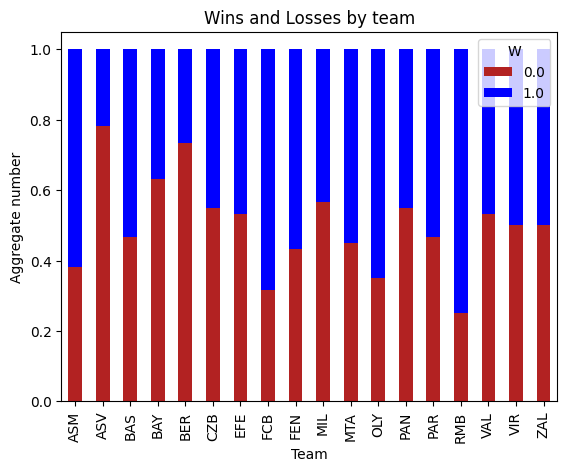

In [31]:
table=pd.crosstab(df.team,df.W)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, color=['firebrick', 'blue'])
plt.title('Wins and Losses by team')
plt.xlabel('Team')
plt.ylabel('Aggregate number')
plt.savefig('Wins and losses by team')
